<center><h1>Artists Data Cleaning</h1></center>

The goal of this notebook is to prepare the artist dataset for the creation of a machine learning model. To achieve this goal, a data cleaning process will be performed that will address the problems identified in the exploratory data analysis notebook (artists_data_analysis.ipynb). This cleaning process will be based on the detection and correction of null values, outliers, errors, and duplicates.

After completing the cleaning process, a second exploratory data analysis will be performed to verify that the problems identified in the first analysis have been resolved. This second exploratory data analysis will be used to validate the cleaned data and detect any additional problems that may have arisen during the cleaning process. The cleaning process is divided into several stages, including:

- Handling duplicates
- Handling missing values 
- Handling outliers
- Data formatting and type conversion
- EDA

In [173]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
from sklearn.impute import KNNImputer
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
# Read data
url = "https://drive.google.com/file/d/1frEhHHnMbib-f56jSNu_aDjxKRqtAcuZ/view?usp=share_link"
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
artists_df = pd.read_csv(dwn_url)

# Handling duplicates

In [151]:
# Drop duplicates based on both the "genres" and "name" columns.
artists_df = artists_df.drop_duplicates(subset = ['name', 'genres'], keep = 'first').reset_index(drop = True)

In [152]:
# Check duplicates based on both the "genres" and "name" columns.
artists_df.duplicated(subset=["genres","name"]).sum()

0

# Handling missing values 

In [153]:
# Imputation with algorithm KNN

cols_to_impute = ['followers', 'popularity']

X = artists_df[cols_to_impute]

X_known = X[X.notnull().all(axis=1)]
X_unknown = X[X.isnull().any(axis=1)]

imputer = KNNImputer(n_neighbors=5)
imputer.fit(X_known)

X_imputed = pd.DataFrame(imputer.transform(X_unknown), columns=cols_to_impute, index=X_unknown.index)

artists_df.loc[X_imputed.index, cols_to_impute] = X_imputed

In [154]:
# Check missing values
artists_df.isnull().sum()

id            0
followers     0
genres        0
name          0
popularity    0
dtype: int64

In [155]:
#Removing artists without a defined genre
artists_df = artists_df.drop(index=artists_df[artists_df['genres']=='[]'].index)

In [156]:
# Check 
len(artists_df.loc[artists_df['genres']=='[]'])

0

# Handling outliers

The winsorization technique is a data preprocessing technique used to deal with outliers in a data set. This technique is based on replacing outliers with values that are at the p percentile or (100th - p) percentile of the data, where p is a value that is set in advance.

For example, if p is set to 5, the winsorization technique will replace all values above the 95th percentile with the value at the 95th percentile, and all values below the 5th percentile with the value at the 5th percentile. In this way, the effect of outliers in the statistical analysis is reduced.

In [157]:
winsorized_followers = mstats.winsorize(artists_df['followers'], limits=[0.05, 0.05])
artists_df['followers'] = winsorized_followers

In [158]:
winsorized_followers = mstats.winsorize(artists_df['popularity'], limits=[0.05, 0.05])
artists_df['popularity'] = winsorized_followers

In [160]:
# Check outliers
def count_outliers(df, col):
    """
    Returns the number of outliers in a column of a DataFrame using the Tukey's method.
    
    Parameters:
    -----------
    df (pandas.DataFrame): Input DataFrame.
    col (str): Name of the column to be analyzed.
        
    Returns:
    --------
    count (int): Number of outliers in the specified column.
        
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5*IQR
    count = ((df[col] > upper_bound) | (df[col] < lower_bound)).sum()
    
    return count

In [166]:
print("Number of outliers in the followers column:", count_outliers(artists_df, "followers"))
print("Number of outliers in the popularity column:", count_outliers(artists_df, "popularity"))

Number of outliers in the followers column: 48562
Number of outliers in the popularity column: 0


# Data formatting and type conversion

In [167]:
# Column values are converted to agree with the Data dictionary
artists_df = artists_df.astype({"id":str, "followers":int, "genres":str, "name":str, "popularity":int}, errors='ignore')

In [168]:
# Check columns and data types
artists_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305153 entries, 45 to 1147213
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          305153 non-null  object
 1   followers   305153 non-null  int32 
 2   genres      305153 non-null  object
 3   name        305153 non-null  object
 4   popularity  305153 non-null  int32 
dtypes: int32(2), object(3)
memory usage: 11.6+ MB


# EDA

In [174]:
# Statistical summary
artists_df.describe()

,followers,popularity
count,305153.000000,305153.000000
mean,8814.372646,18.781031
std,19772.366976,16.436842
min,17.000000,0.000000
25%,151.000000,3.000000
50%,847.000000,15.000000
75%,4978.000000,31.000000
max,80112.000000,52.000000


In [175]:
# Boxplot
def plot_boxplot(df, col):
    '''
    Creates a boxplot of a numeric variable in a pandas DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data to be plotted.
    col (str): The name of the column in the DataFrame to be plotted.

    Returns:
    None
    '''
    plt.figure(figsize=(8,6))
    df.boxplot(column=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

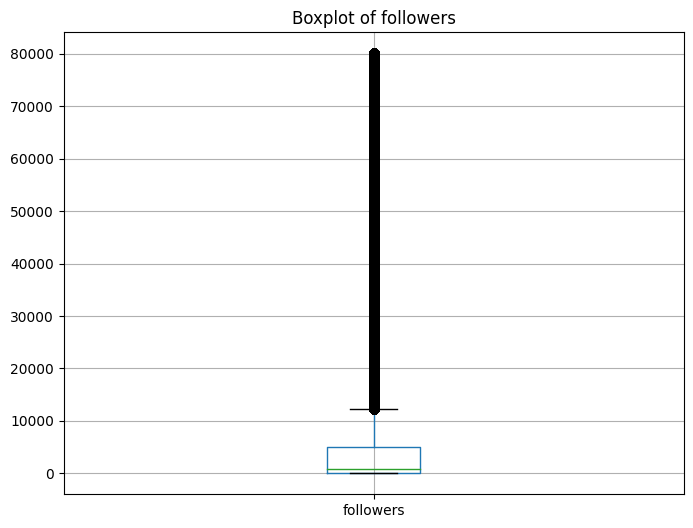

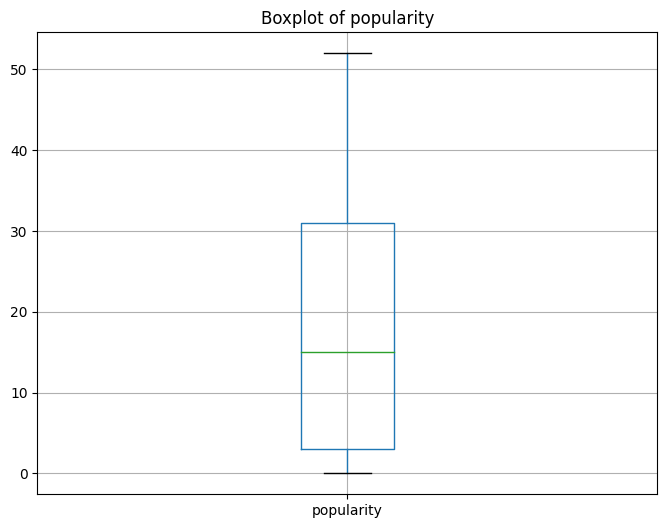

In [176]:
plot_boxplot(artists_df, "followers")
plot_boxplot(artists_df, "popularity")

In [177]:
# Pie Chart
def pie_chart(df, col, top_n=10):
    """
    Creates a pie chart with the most frequent categories.

    Parameters:
    df (pandas.DataFrame): The data to use for creating the pie chart.
    col (str): The name of the categorical column to use for creating the pie chart.
    top_n (int): The number of most frequent categories to include in the chart (default 10).

    Returns:
    None (displays a plot)

    """
    # Get value counts for column
    counts = df[col].value_counts()

    # Get the most frequent categories
    most_frequent = counts.nlargest(top_n)

    # Create the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(most_frequent, labels=most_frequent.index, autopct='%1.1f%%')
    plt.title(f"Pie chart of {col} with the most frequent categories", fontsize=16)
    plt.show()

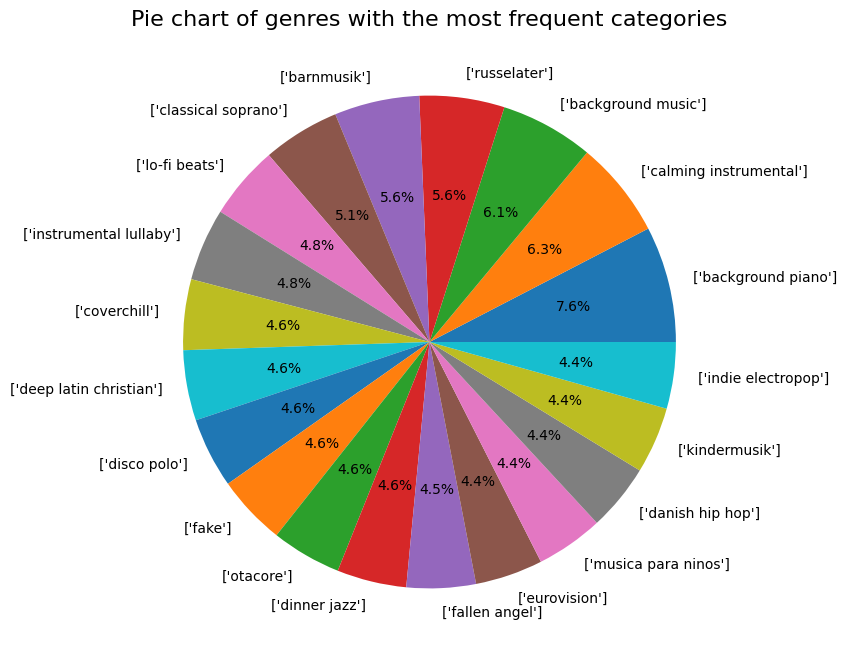

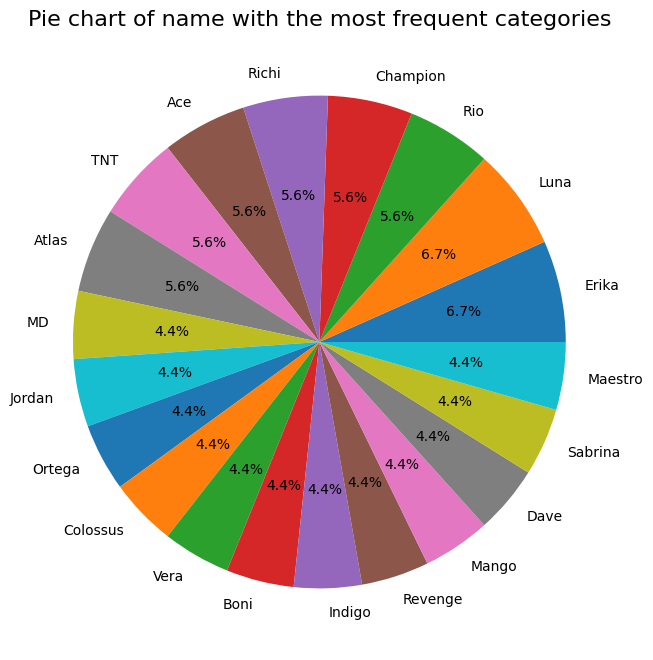

In [178]:
pie_chart(artists_df,"genres", 20)
pie_chart(artists_df,"name", 20)